Este notebook simples em Python foi projetado para facilitar a extração de arquivos .zip diretamente no ambiente do Google Colab. É ideal para projetos de Machine Learning ou Análise de Dados onde o dataset de trabalho está compactado e precisa ser descompactado para uso.

1. Extração e Organização do Dataset

Este script é responsável pelo upload e descompactação do dataset. Utiliza a API do Colab (files.upload) para interagir com o sistema de arquivos local, descompacta o arquivo .zip para um diretório (/content/dataset) e valida a estrutura de pastas.

In [ ]:
from google.colab import files
import zipfile
import os

print("Selecione o arquivo .zip do dataset no seu computador...")
uploaded = files.upload()

zip_name = list(uploaded.keys())[0]
zip_path = f"/content/{zip_name}"

extract_path = "/content/dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extraído em:", extract_path)
print("Pastas encontradas:", os.listdir(extract_path))

Selecione o arquivo .zip do dataset no seu computador...


Saving apples_or_tomatoes.zip.zip to apples_or_tomatoes.zip (3).zip
Dataset extraído em: /content/dataset
Pastas encontradas: ['test', 'train']


2. Importação e Configuração

Esta célula importa todas as bibliotecas necessárias para o pipeline de machine learning, incluindo TensorFlow/Keras para a construção do modelo e scikit-learn para as métricas de avaliação. O seed aleatório é fixado para garantir a reprodutibilidade dos resultados do modelo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc

tf.random.set_seed(42)
np.random.seed(42)

3. Configuração dos Diretórios de Dados

Define os caminhos de diretório para os conjuntos de dados de treino e teste. A função os.path.join é usada para criar caminhos de forma segura. O conteúdo de cada pasta é listado para validação da estrutura do dataset.

In [ ]:
train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")

print("Conteúdo da pasta train:", os.listdir(train_dir))
print("Conteúdo da pasta test:", os.listdir(test_dir))


Conteúdo da pasta train: ['apples', 'tomatoes']
Conteúdo da pasta test: ['apples', 'tomatoes']


4. Criação dos Geradores de Dados

Configura os geradores de dados com ImageDataGenerator. Este processo faz a normalização de pixel (rescale=1./255) e o redimensionamento de imagens, criando um fluxo de dados em lotes eficiente para o treinamento. O class_mode é definido como binary e o shuffle é desativado para o conjunto de teste.

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False
)

print("Classes detectadas:", train_data.class_indices)

Found 294 images belonging to 2 classes.
Found 97 images belonging to 2 classes.
Classes detectadas: {'apples': 0, 'tomatoes': 1}


5. Visualização de Amostras

Uma função utilitária para inspeção visual de um lote de dados. next(generator) recupera um lote de imagens, que é então plotado com matplotlib para verificar se a entrada de dados para o modelo está correta.

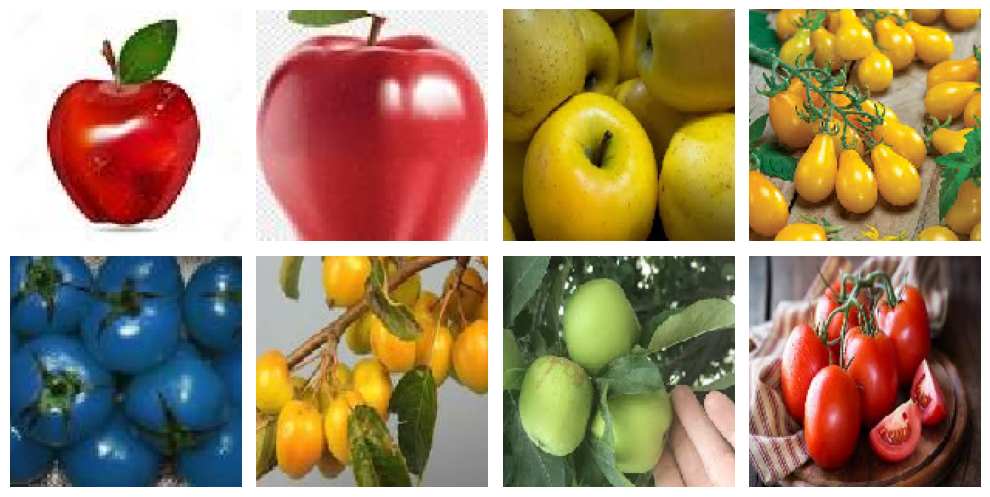

In [ ]:
def plot_samples(generator, num=8):
    imgs, lbls = next(generator)
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(4, 4, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(train_data)


6. Definição da Arquitetura do Modelo

Define e compila uma Rede Neural Convolucional (CNN). A arquitetura Sequential inclui múltiplas camadas Conv2D e MaxPooling2D para extração de características, além de uma camada Dropout para regularização. O modelo é compilado com o otimizador Adam, binary_crossentropy para perda, e as métricas accuracy e AUC.

In [ ]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'), MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'), MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), activation='relu'), MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

model = create_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

7. Treinamento do Modelo

Inicia o treinamento do modelo usando a função model.fit(). Ele itera por 20 epochs e alimenta o modelo com dados a partir dos geradores de treino e validação. O history do treinamento é retornado para análise posterior.

In [ ]:
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=20,
    validation_data=test_data,
    validation_steps=len(test_data),
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5545 - auc: 0.5795 - loss: 0.6905 - val_accuracy: 0.5876 - val_auc: 0.6960 - val_loss: 0.6564
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6236 - auc: 0.7279 - loss: 0.6373 - val_accuracy: 0.6186 - val_auc: 0.7280 - val_loss: 0.6416
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6948 - auc: 0.7597 - loss: 0.6007 - val_accuracy: 0.6804 - val_auc: 0.7319 - val_loss: 0.6061
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6733 - auc: 0.7668 - loss: 0.5842 - val_accuracy: 0.6598 - val_auc: 0.7496 - val_loss: 0.5925
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6878 - auc: 0.7654 - loss: 0.6080 - val_accuracy: 0.6701 - val_auc: 0.7438 - val_loss: 0.6286
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7336 - auc: 0.8050 - loss: 0.5507 - val_accuracy: 0.6598 - val_auc: 0.7653 - val_loss: 0.6182
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0

8. Avaliação Final

Avalia o desempenho do modelo no conjunto de teste. A função model.evaluate retorna as métricas de perda e desempenho, enquanto model.predict gera as previsões do modelo. Um classification_report detalhado, contendo precisão, revocação e F1-score, é gerado para uma análise completa.

In [ ]:
test_loss, test_acc, test_auc = model.evaluate(test_data)
print("Test accuracy:", test_acc)
print("Test AUC:", test_auc)

y_pred = model.predict(test_data)
y_pred_class = (y_pred > 0.5).astype(int)
y_true = test_data.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_class, target_names=['apple', 'tomatoes']))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.5983 - auc: 0.6805 - loss: 0.7758
🎯 Test accuracy: 0.6597937941551208
🎯 Test AUC: 0.8518518805503845
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step
Classification Report:
              precision    recall  f1-score   support

       apple       0.84      0.48      0.61        54
    tomatoes       0.58      0.88      0.70        43

    accuracy                           0.66        97
   macro avg       0.71      0.68      0.65        97
weighted avg       0.72      0.66      0.65        97



9. Visualização do Histórico de Treinamento

Uma função final para visualizar graficamente o histórico de treinamento. Ele plota as curvas de loss, accuracy e AUC para os conjuntos de treino e validação, permitindo diagnosticar problemas como overfitting ou underfitting.


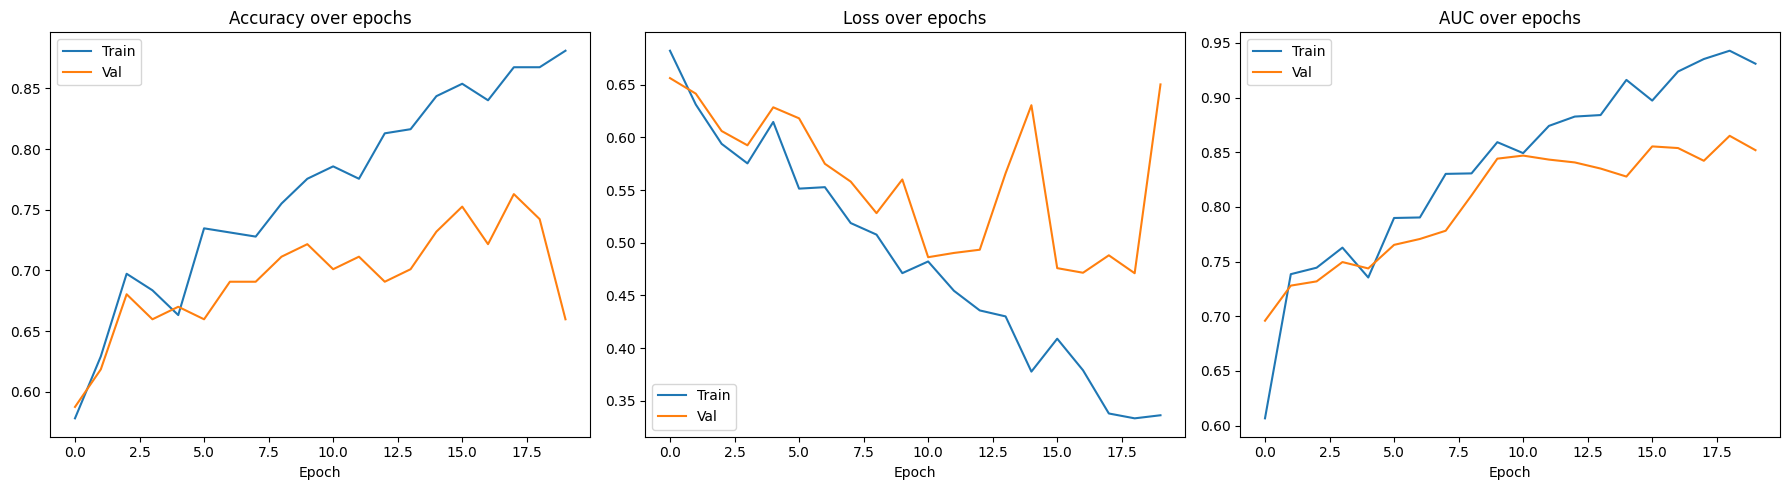

In [ ]:
def plot_history(hist):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    metrics = ['accuracy', 'loss', 'auc']
    titles = ['Accuracy', 'Loss', 'AUC']
    for i, metric in enumerate(metrics):
        axes[i].plot(hist.history[metric], label='Train')
        axes[i].plot(hist.history[f'val_{metric}'], label='Val')
        axes[i].set_title(f'{titles[i]} over epochs')
        axes[i].set_xlabel('Epoch')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_history(history)